In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import mlab

In [2]:
df = pd.read_csv("../data/creditcard_fraud_subsample.csv", sep = ';')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,129095.0,-1.836940,-1.646764,-3.381168,0.473354,0.074243,-0.446751,3.791907,-1.351045,0.095186,...,0.010663,1.786681,-0.151178,-0.582098,-0.956062,-0.334369,0.715600,0.370450,720.80,1
1,69394.0,1.140431,1.134243,-1.429455,2.012226,0.622800,-1.152923,0.221159,0.037372,0.034486,...,-0.367136,-0.891627,-0.160578,-0.108326,0.668374,-0.352393,0.071993,0.113684,1.00,1
2,148476.0,-1.125092,3.682876,-6.556168,4.016731,-0.425571,-2.031210,-2.650137,1.131249,-2.946890,...,1.185580,1.348156,-0.053686,0.284122,-1.174469,-0.087832,0.718790,0.676216,0.76,1
3,48533.0,1.243848,0.524526,-0.538884,1.209196,0.479538,-0.197429,0.049166,0.037792,0.128119,...,-0.051660,-0.084089,-0.192846,-0.917392,0.681953,-0.194419,0.045917,0.040136,1.00,1
4,154493.0,-7.381547,-7.449015,-4.696287,3.728439,6.198304,-6.406267,-5.831452,1.457175,-0.646203,...,1.176575,-0.978692,-0.278330,-0.635874,0.123539,0.404729,0.704915,-1.229992,35.00,1


In [3]:
df = df.drop(['Time'], axis=1)
df['Amount_norm'] = (df.Amount-df.Amount.mean())/df.Amount.std()
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_norm
0,-1.836940,-1.646764,-3.381168,0.473354,0.074243,-0.446751,3.791907,-1.351045,0.095186,-0.084500,...,1.786681,-0.151178,-0.582098,-0.956062,-0.334369,0.715600,0.370450,720.80,1,2.625216
1,1.140431,1.134243,-1.429455,2.012226,0.622800,-1.152923,0.221159,0.037372,0.034486,-1.879644,...,-0.891627,-0.160578,-0.108326,0.668374,-0.352393,0.071993,0.113684,1.00,1,-0.360630
2,-1.125092,3.682876,-6.556168,4.016731,-0.425571,-2.031210,-2.650137,1.131249,-2.946890,-4.816401,...,1.348156,-0.053686,0.284122,-1.174469,-0.087832,0.718790,0.676216,0.76,1,-0.361625
3,1.243848,0.524526,-0.538884,1.209196,0.479538,-0.197429,0.049166,0.037792,0.128119,-0.552903,...,-0.084089,-0.192846,-0.917392,0.681953,-0.194419,0.045917,0.040136,1.00,1,-0.360630
4,-7.381547,-7.449015,-4.696287,3.728439,6.198304,-6.406267,-5.831452,1.457175,-0.646203,-4.029129,...,-0.978692,-0.278330,-0.635874,0.123539,0.404729,0.704915,-1.229992,35.00,1,-0.219592


In [4]:
def train_test_fn(df , proportion):

    msk = np.random.rand(len(df)) < proportion

    train = df[msk]

    test = df[~msk]
    
    return train, test

def frange(start, stop, step):
     i = start
     while i < stop:
         yield i
         i += step
        
def confusion_matrix_fn(truth,result):
    c11 = sum(truth*result)
    c10 = sum(truth*(1-result))
    c01 = sum((1-truth)*result)
    c00 = sum((1-truth)*(1-result))
    tab = np.matrix([[c11, c10], [c01, c00]])
    return tab

def precision_fn(truth,result):
    c11 = sum(truth*result)
    #c10 = sum(truth*(1-result))
    c01 = sum((1-truth)*result)
    #c00 = sum((1-truth)*(1-result))
    prec = c11/(c11+c01)
    return prec

def recall_fn(truth,result):
    c11 = sum(truth*result)
    c10 = sum(truth*(1-result))
    #c01 = sum((1-truth)*result)
    #c00 = sum((1-truth)*(1-result))
    rec = c11/(c11+c10)
    return rec

def F_score_fn(truth,result):
    c11 = sum(truth*result)
    c10 = sum(truth*(1-result))
    c01 = sum((1-truth)*result)
    prec = c11/(c11+c01)
    rec = c11/(c11+c10)
    F=2/(1/prec+1/rec)
    
    return F

In [7]:
accuracies = []
precisions = []
recalls = []
F_scores = []

proportion = 0.6
iterations = 100

for i in range(iterations-1):
    train, test = train_test_fn(df, proportion) 
    X = train.drop(['Amount','Class'], axis=1)
    y = train['Class']

    X_test = test.drop(['Amount','Class'], axis=1)
    y_test = test['Class']
    
    logisticRegr = LogisticRegression(penalty = 'l2' ,solver = 'liblinear')
    logistic_model = logisticRegr.fit(X, y) 
    
    y_predicted = logistic_model.predict(X_test)
    accuracies.append(np.mean(np.equal(y_predicted,y_test))) 
    precisions.append(precision_fn(y_predicted,y_test))
    recalls.append(recall_fn(y_predicted,y_test))
    F_scores.append(F_score_fn(y_predicted,y_test))


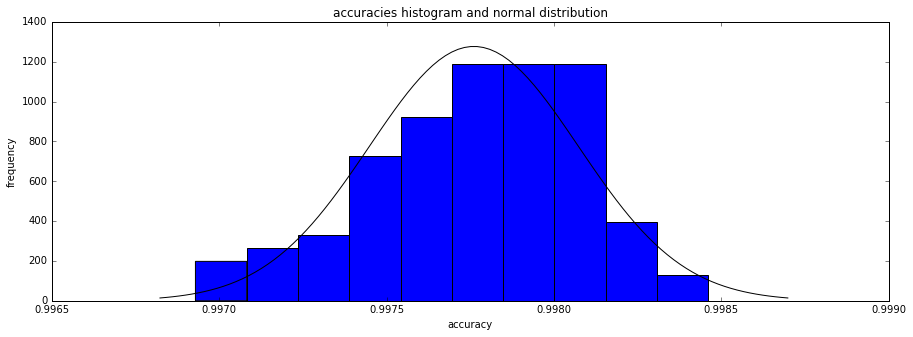

In [8]:
plt.figure(1,figsize=(15,5))
plt.hist(accuracies , normed = 1)
mu = np.mean(accuracies)
sigma = np.std(accuracies)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma) , color="black")
plt.title("accuracies histogram and normal distribution")
plt.xlabel("accuracy")
plt.ylabel("frequency")
plt.show()

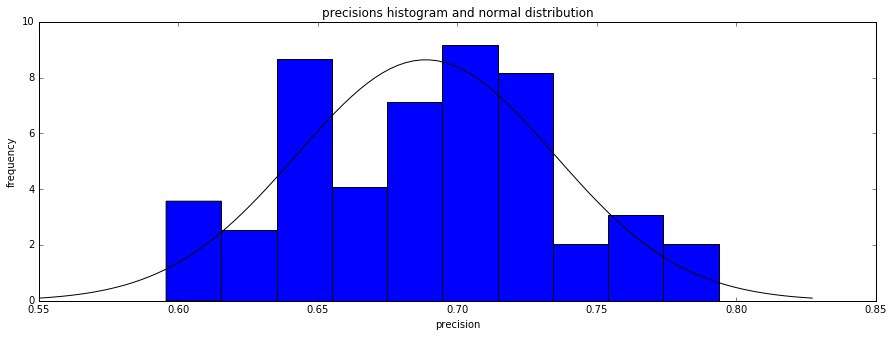

In [18]:
plt.figure(1,figsize=(15,5))
plt.hist(precisions , normed = 1)
mu = np.mean(precisions)
sigma = np.std(precisions)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma) , color="black")
plt.title("precisions histogram and normal distribution")
plt.xlabel("precision")
plt.ylabel("frequency")
plt.show()

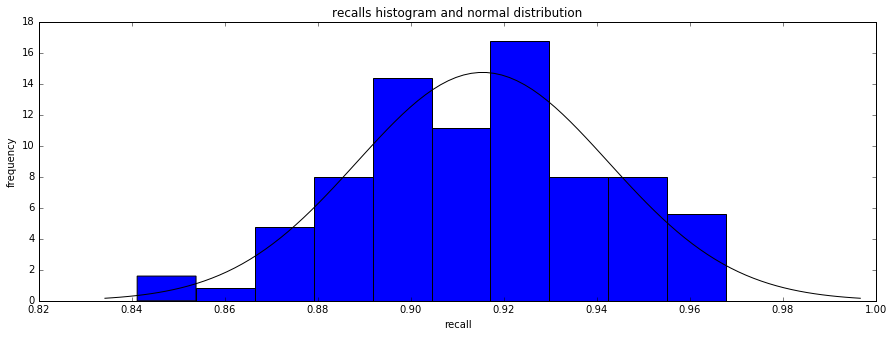

In [19]:
plt.figure(1,figsize=(15,5))
plt.hist(recalls , normed = 1)
mu = np.mean(recalls)
sigma = np.std(recalls)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma) , color="black")
plt.title("recalls histogram and normal distribution")
plt.xlabel("recall")
plt.ylabel("frequency")
plt.show()

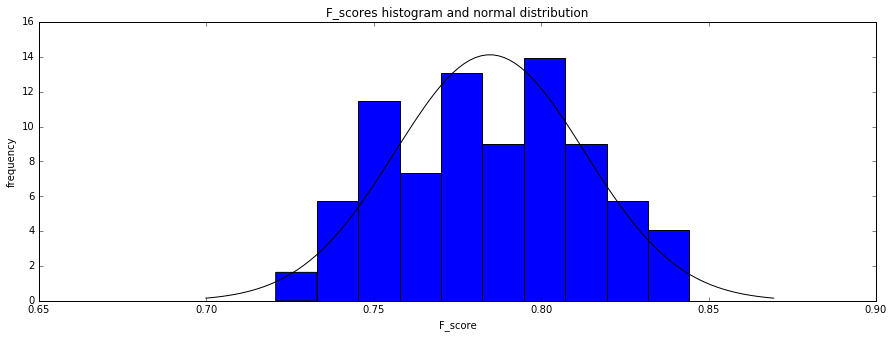

In [20]:
plt.figure(1,figsize=(15,5))
plt.hist(F_scores , normed = 1)
mu = np.mean(F_scores)
sigma = np.std(F_scores)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma) , color="black")
plt.title("F_scores histogram and normal distribution")
plt.xlabel("F_score")
plt.ylabel("frequency")
plt.show()

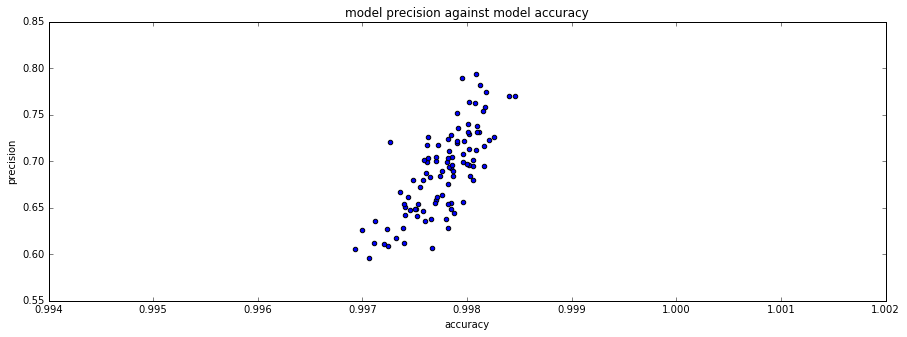

In [11]:
plt.figure(1,figsize=(15,5))
plt.scatter(accuracies, precisions)
plt.title("model precision against model accuracy")
plt.xlabel("accuracy")
plt.ylabel("precision")
plt.show()

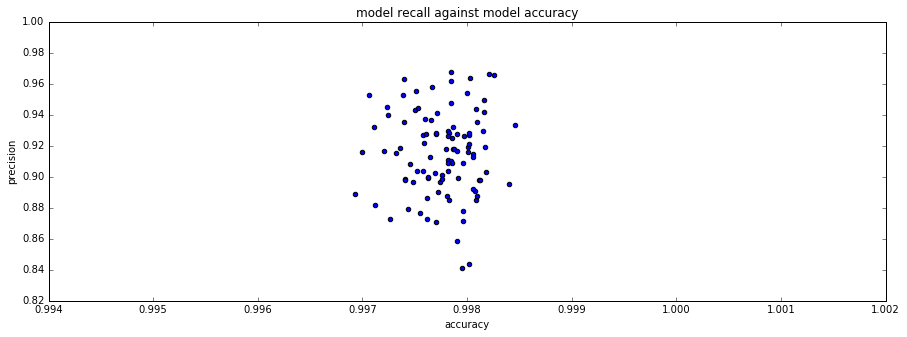

In [10]:
plt.figure(1,figsize=(15,5))
plt.scatter(accuracies, recalls)
plt.title("model recall against model accuracy")
plt.xlabel("accuracy")
plt.ylabel("precision")
plt.show()

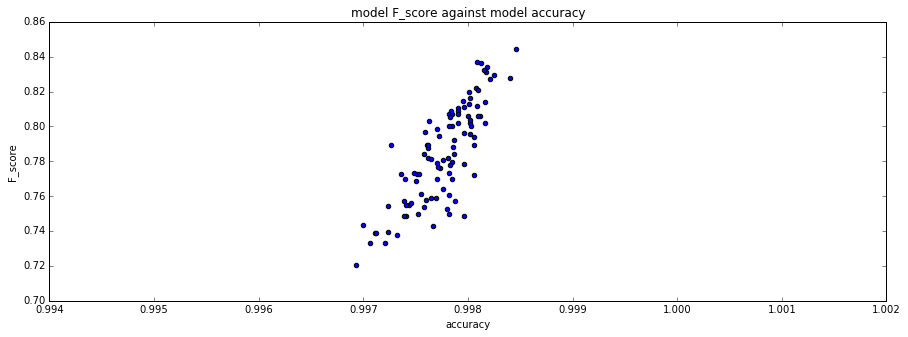

In [13]:
plt.figure(1,figsize=(15,5))
plt.scatter(accuracies, F_scores)
plt.title("model F_score against model accuracy")
plt.xlabel("accuracy")
plt.ylabel("F_score")
plt.show()

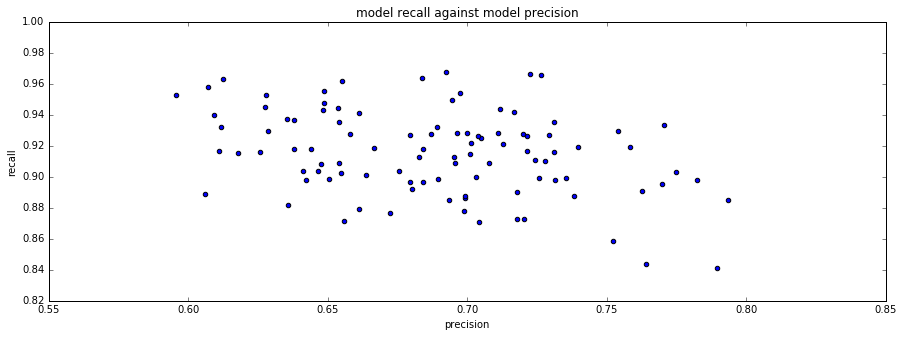

In [14]:
plt.figure(1,figsize=(15,5))
plt.scatter(precisions, recalls)
plt.title("model recall against model precision")
plt.xlabel("precision")
plt.ylabel("recall")
plt.show()

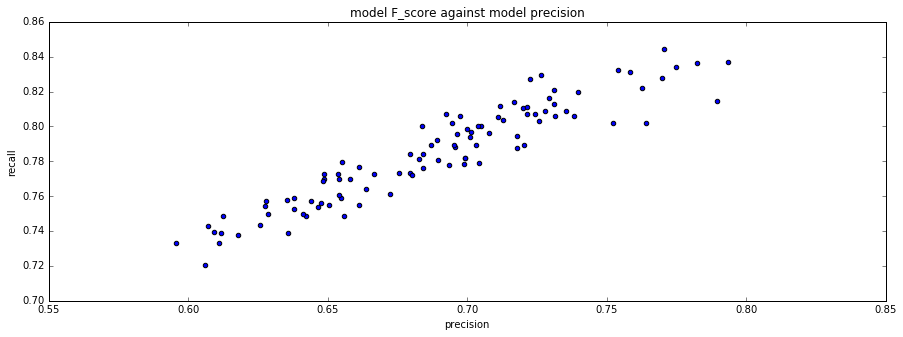

In [16]:
plt.figure(1,figsize=(15,5))
plt.scatter(precisions, F_scores)
plt.title("model F_score against model precision")
plt.xlabel("precision")
plt.ylabel("F_score")
plt.show()

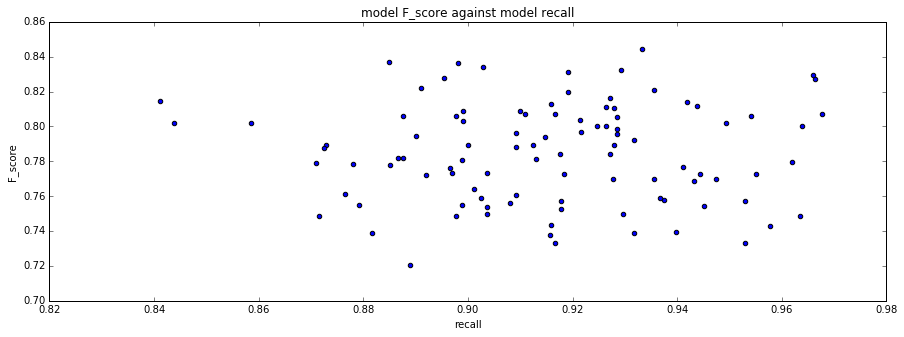

In [17]:
plt.figure(1,figsize=(15,5))
plt.scatter(recalls, F_scores)
plt.title("model F_score against model recall")
plt.xlabel("recall")
plt.ylabel("F_score")
plt.show()

In [29]:
proportions = []

accuracies = []
precisions = []
recalls = []
F_scores = []


iterations = 100

for proportion in frange(0.1,0.9,0.1):

    for i in range(iterations-1):
        train, test = train_test_fn(df, proportion) 
        X = train.drop(['Amount','Class'], axis=1)
        y = train['Class']
        
        X_test = test.drop(['Amount','Class'], axis=1)
        y_test = test['Class']
    
        logisticRegr = LogisticRegression(penalty = 'l2' ,solver = 'liblinear')
        logistic_model = logisticRegr.fit(X, y) 
    
        y_predicted = logistic_model.predict(X_test)
        accuracies.append(np.mean(np.equal(y_predicted,y_test))) 
        precisions.append(precision_fn(y_predicted,y_test))
        recalls.append(recall_fn(y_predicted,y_test))
        F_scores.append(F_score_fn(y_predicted,y_test))
        proportions.append(proportion)

qualities = pd.DataFrame(list(zip(proportions,accuracies,precisions,recalls,F_scores)), 
                         columns=['proportions','accuracies','precisions','recalls','F_scores'])

In [33]:
qualities

,proportions,accuracies,precisions,recalls,F_scores
0,0.1,0.996648,0.507246,0.897436,0.648148
1,0.1,0.997854,0.792593,0.839216,0.815238
2,0.1,0.997810,0.721190,0.889908,0.796715
3,0.1,0.997267,0.625455,0.891192,0.735043
4,0.1,0.997550,0.696296,0.866359,0.772074
5,0.1,0.997571,0.684015,0.880383,0.769874
6,0.1,0.998081,0.777358,0.880342,0.825651
7,0.1,0.997616,0.762082,0.823293,0.791506
8,0.1,0.998188,0.771536,0.907489,0.834008
9,0.1,0.997233,0.606742,0.890110,0.721604


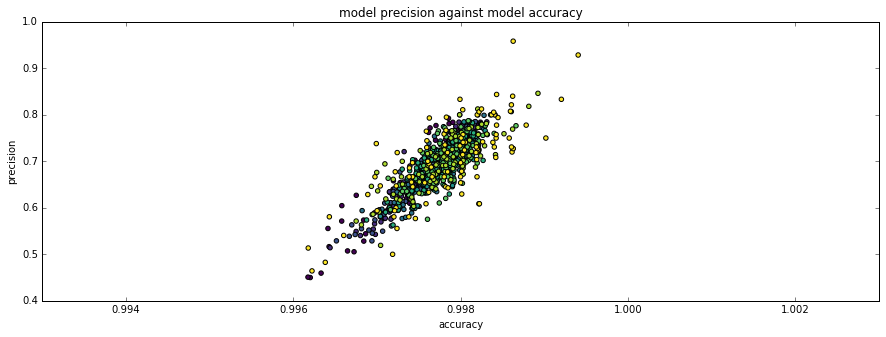

In [35]:
plt.figure(1,figsize=(15,5))
plt.scatter(qualities.accuracies, qualities.precisions,  c = qualities.proportions , cmap='viridis')
plt.title("model precision against model accuracy")
plt.xlabel("accuracy")
plt.ylabel("precision")
plt.show()

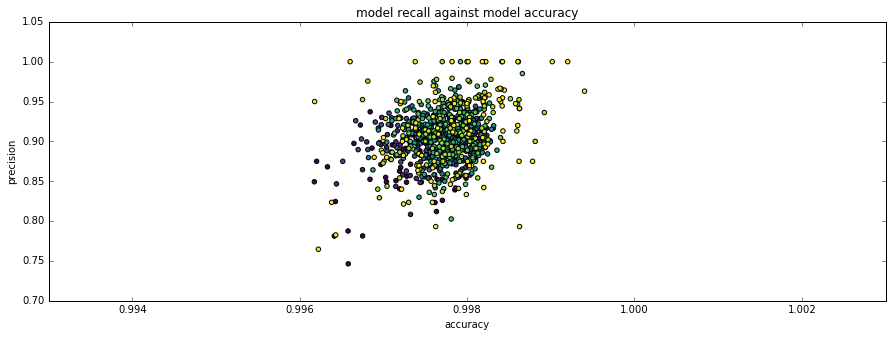

In [36]:
plt.figure(1,figsize=(15,5))
plt.scatter(qualities.accuracies, qualities.recalls,  c = qualities.proportions , cmap='viridis')
plt.title("model recall against model accuracy")
plt.xlabel("accuracy")
plt.ylabel("precision")
plt.show()

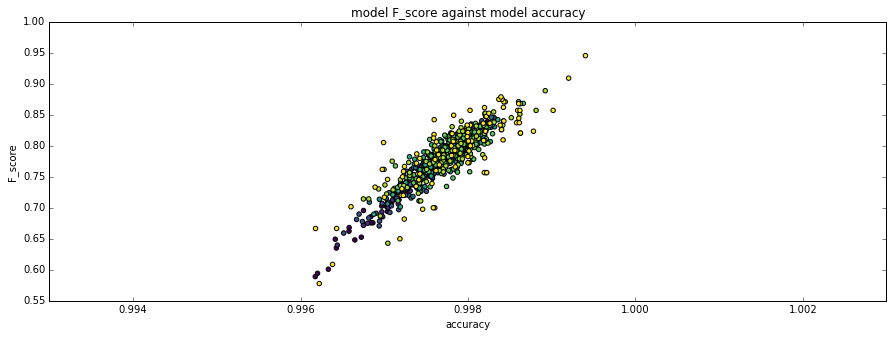

In [37]:
plt.figure(1,figsize=(15,5))
plt.scatter(qualities.accuracies, qualities.F_scores,  c = qualities.proportions , cmap='viridis')
plt.title("model F_score against model accuracy")
plt.xlabel("accuracy")
plt.ylabel("F_score")
plt.show()

In [61]:
props = set(qualities.proportions)

In [63]:
accuracies2 = []
predictions = []

for prop in props:

    OLS = sklearn.linear_model.LinearRegression()
    OLS.fit(qualities[qualities.proportions==prop][['accuracies']] , qualities[qualities.proportions==prop][['F_scores']])

    predOLS = OLS.predict(qualities[qualities.proportions==prop][['accuracies']])
    
    predictions.append(predOLS)
    accuracies2.append(qualities[qualities.proportions==prop].accuracies)

In [74]:
import itertools
merged = list(itertools.chain.from_iterable(predictions))

In [75]:
qualities['predictions'] = merged

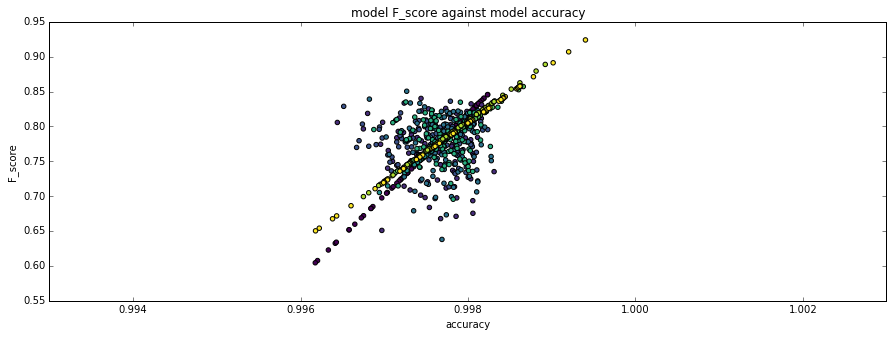

In [78]:
plt.figure(1,figsize=(15,5))
plt.scatter(qualities.accuracies, qualities.predictions,  c = qualities.proportions , cmap='viridis')
plt.title("model F_score against model accuracy")
plt.xlabel("accuracy")
plt.ylabel("F_score")
plt.show()

In [ ]:
plt.figure(1,figsize=(15,5))
plt.scatter(X, y, color = "blue", label = "Y observed")
plt.plot(X, predOLS, color = "r", linewidth = 3, label = "Regression line (OLS)")
plt.plot(X, predmed, color = "g", linewidth = 3, label = "regression line (Median)")
plt.plot(X, pred005, color = "g", linewidth = 1 ,  label = "other quantile regression lines")
plt.plot(X, pred01, color = "g", linewidth = 1)
plt.plot(X, pred02, color = "g", linewidth = 1)
plt.plot(X, pred08, color = "g", linewidth = 1)
plt.plot(X, pred09, color = "g", linewidth = 1)
plt.plot(X, pred095, color = "g", linewidth = 1)
plt.xlabel("NOX")
plt.ylabel("Housing Price")
plt.title("Scatterplot, Housing Price vs. NOX, OLS- and Quantile-Regressions (q equals 0.05, 0.1, 0.2, 0.5, 0.8, 0.9 and 0.95 )")
plt.legend()
plt.show()

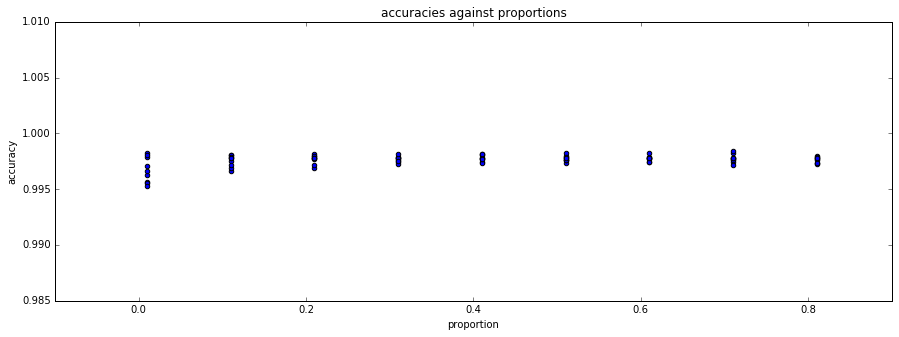

In [22]:
plt.figure(1,figsize=(15,5))
plt.scatter(qualities.proportions, qualities.accuracies)
plt.title("accuracies against proportions")
plt.xlabel("proportion")
plt.ylabel("accuracy")
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

all_data = [qualities[qualities.proportions == prop]['accuracies'] for prop in frange(0.05,0.9,0.05)]

# plot violin plot
axes[0].violinplot(all_data,
                   showmeans=False,
                   showmedians=True)
axes[0].set_title('Violin plot')

# plot box plot
axes[1].boxplot(all_data)
axes[1].set_title('Box plot')

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(all_data))])
    ax.set_xlabel('proportions')
    ax.set_ylabel('accuracy')

# add x-tick labels
plt.setp(axes, xticks=[y + 1 for y in range(len(all_data))]) #,
         #xticklabels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9'])
plt.show()

In [ ]:
# das geht 1 zu 1 nach den angegebenen Formeln

def confusion_matrix_fn(truth,result):
    c11 = sum(truth*result)
    c10 = sum(truth*(1-result))
    c01 = sum((1-truth)*result)
    c00 = sum((1-truth)*(1-result))
    tab = np.matrix([[c11, c10], [c01, c00]])
    return tab

In [ ]:
matrix_logistic = confusion_matrix_fn(logistic_model.predict(X_test),y_test)
matrix_logistic

In [ ]:
# das geht 1 zu 1 nach den angegebenen Formeln

def precision_fn(truth,result):
    c11 = sum(truth*result)
    #c10 = sum(truth*(1-result))
    c01 = sum((1-truth)*result)
    #c00 = sum((1-truth)*(1-result))
    prec = c11/(c11+c01)
    return prec

In [ ]:
def recall_fn(truth,result):
    c11 = sum(truth*result)
    c10 = sum(truth*(1-result))
    #c01 = sum((1-truth)*result)
    #c00 = sum((1-truth)*(1-result))
    rec = c11/(c11+c10)
    return rec

In [ ]:
precision_fn(logistic_model.predict(X_test),y_test) # logistische Regression mit Formel beurteilen

In [ ]:
# das geht 1 zu 1 nach den angegebenen Formeln

def F_score_fn(truth,result):
    c11 = sum(truth*result)
    c10 = sum(truth*(1-result))
    c01 = sum((1-truth)*result)
    prec = c11/(c11+c01)
    rec = c11/(c11+c10)
    F=2/(1/prec+1/rec)
    
    return F

In [ ]:
recall_fn(logistic_model.predict(X_test),y_test) # logistische Regression mit Formel beurteilen

In [ ]:
F_score_fn(logistic_model.predict(X_test),y_test) # logistische Regression mit Formel beurteilen